🔍 Carregando dataset CQCC para teste SVM...
Total: 36975 arquivos (Real=19999, Fake=16976)
Extraindo CQCC... 100.00% (36975/36975)

📦 Concluído em 6240.63s
📌 TAMANHO TESTE: (7182, 40) (7182,)
📁 Carregando modelo SVM CQCC...
✅ Modelo carregado!

====== CLASSIFICATION REPORT (SVM CQCC) ======
              precision    recall  f1-score   support

        Real       0.82      0.93      0.87      4000
        Fake       0.89      0.75      0.81      3182

    accuracy                           0.85      7182
   macro avg       0.86      0.84      0.84      7182
weighted avg       0.85      0.85      0.85      7182

🎯 Accuracy: 0.8489278752436648 

🧱 Matriz de Confusão:
[[3708  292]
 [ 793 2389]]

📈 AUC ROC: 0.9569


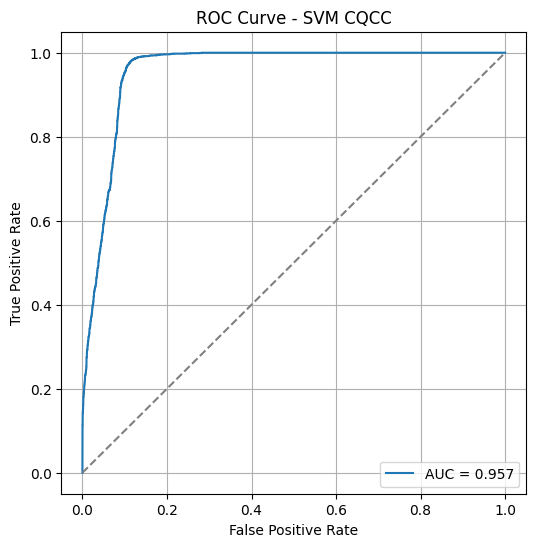

In [5]:
# ======================================================
# 1. Importações
# ======================================================
import os
import numpy as np
import librosa
import soundfile as sf
import joblib
import scipy.fft
import time
from tqdm import tqdm

from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    roc_curve, 
    auc
)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# ======================================================
# 2. Configurações
# ======================================================
DATASET_DIR = ""   # <-- MESMO DIRETÓRIO USADO NA CNN E EXTRAÇÃO CQCC
REAL_DIR = os.path.join(DATASET_DIR, "real")
FAKE_DIR = os.path.join(DATASET_DIR, "fake")

SVM_MODEL_PATH = "svm_cqcc.pkl"  # <-- Modelo treinado com CQCC

SAMPLE_RATE = 16000
N_CQCC = 40
BINS_PER_OCTAVE = 96

# ======================================================
# 3. Funções auxiliares
# ======================================================
def load_audio(path):
    wav, sr = sf.read(path)
    if wav.ndim > 1:
        wav = wav.mean(axis=1)
    if sr != SAMPLE_RATE:
        wav = librosa.resample(
            wav.astype(np.float32),
            orig_sr=sr,
            target_sr=SAMPLE_RATE
        )
    return wav.astype(np.float32)


# -------- CQCC --------
def extract_cqcc(wave, sr=16000, n_cqcc=40, bins_per_octave=96):
    """
    CQCC = DCT(log(CQT^2))
    CQT → log-power → DCT → coeficientes
    """

    # 1) CQT complex
    CQT = librosa.cqt(
        wave,
        sr=sr,
        hop_length=128,
        fmin=20,
        n_bins=8 * bins_per_octave,
        bins_per_octave=bins_per_octave,
        pad_mode="reflect"     # evita janelas curtas
    )

    # 2) Espectro de potência
    power = np.abs(CQT)**2

    # 3) Log-power
    log_power = np.log(power + 1e-12)

    # 4) DCT → cepstrum
    cqcc = scipy.fft.dct(log_power, axis=0, norm='ortho')

    # 5) Mantém primeiros coeficientes
    cqcc = cqcc[:n_cqcc, :]

    return cqcc


# ============================================================
# 2. Vetor fixo (média temporal)
# ============================================================
def extract_cqcc_mean(wave, sr=16000, n_cqcc=40):
    cq = extract_cqcc(wave, sr=sr, n_cqcc=n_cqcc)
    return np.mean(cq, axis=1)


def count_audio_files(root):
    total = 0
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith((".wav", ".flac", ".mp3")):
                total += 1
    return total


# ======================================================
# 4. Carregar dataset mantendo estrutura por pessoa (igual CNN)
# ======================================================
def load_dataset_cqcc(real_dir, fake_dir):

    total_real = count_audio_files(real_dir)
    total_fake = count_audio_files(fake_dir)
    total_files = total_real + total_fake
    print(f"Total: {total_files} arquivos (Real={total_real}, Fake={total_fake})")

    X, y, persons = [], [], []
    loaded = 0

    for label_dir, label in [(real_dir, 0), (fake_dir, 1)]:
        for person in os.listdir(label_dir):
            person_path = os.path.join(label_dir, person)

            if os.path.isdir(person_path):
                for root, _, files in os.walk(person_path):
                    for f in files:
                        if f.lower().endswith((".wav",".flac",".mp3")):
                            path = os.path.join(root,f)

                            wav = load_audio(path)
                            feat = extract_cqcc_mean(wav)

                            X.append(feat)
                            y.append(label)
                            persons.append(person)

                            loaded += 1
                            percent = (loaded / total_files) * 100
                            print(f"\rExtraindo CQCC... {percent:.2f}% ({loaded}/{total_files})", end="")

    print("\n")
    return np.array(X), np.array(y), np.array(persons)

# ======================================================
# 5. Carregar dataset
# ======================================================
print("🔍 Carregando dataset CQCC para teste SVM...")
start = time.time()
X, y, persons = load_dataset_cqcc(REAL_DIR, FAKE_DIR)
print(f"📦 Concluído em {time.time()-start:.2f}s")

# ======================================================
# 6. Criar conjunto de teste baseado em SPEAKER
# ======================================================
from sklearn.model_selection import train_test_split

unique_persons = np.unique(persons)
_, test_persons = train_test_split(unique_persons, test_size=0.2, random_state=42)

test_mask = np.isin(persons, test_persons)
X_test = X[test_mask]
y_test = y[test_mask]

print("📌 TAMANHO TESTE:", X_test.shape, y_test.shape)

# ======================================================
# 7. Carregar e avaliar modelo SVM
# ======================================================
print("📁 Carregando modelo SVM CQCC...")
svm = joblib.load(SVM_MODEL_PATH)
print("✅ Modelo carregado!\n")

y_pred = svm.predict(X_test)
y_score = svm.predict_proba(X_test)[:, 1]

print("====== CLASSIFICATION REPORT (SVM CQCC) ======")
print(classification_report(y_test, y_pred, target_names=["Real","Fake"]))

print("🎯 Accuracy:", accuracy_score(y_test, y_pred), "\n")

print("🧱 Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# ======================================================
# 8. Curve ROC + AUC
# ======================================================
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

print(f"\n📈 AUC ROC: {roc_auc:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM CQCC")
plt.legend()
plt.grid()
plt.show()


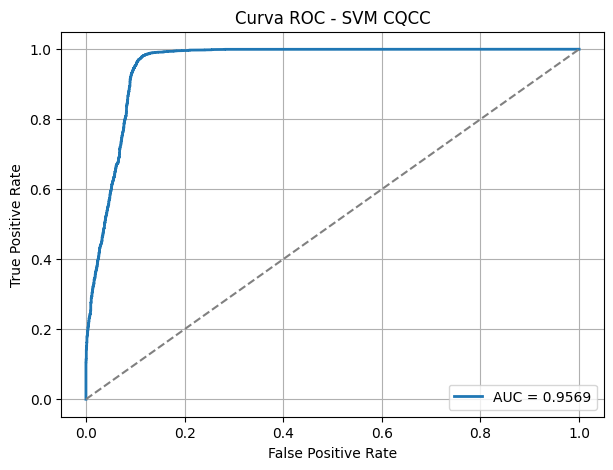

AUC (Área sob a Curva ROC): 0.9569


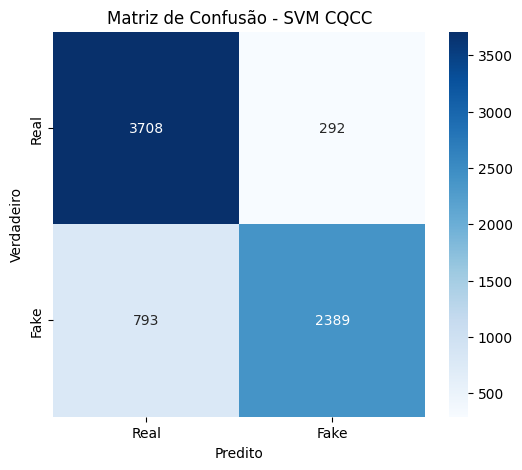

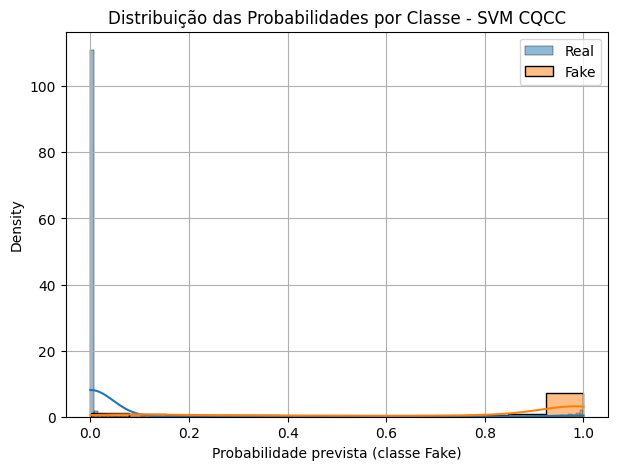

===== MÉTRICAS COMPLEMENTARES =====
Precisão (Precision): 0.8911
Recall (Sensibilidade): 0.7508
F1-Score: 0.8149
MAE das Probabilidades: 0.1600

===== DESEMPENHO DO MODELO SVM =====
Tempo médio por amostra: 0.338 ms
Amostras por segundo (FPS): 2961.80


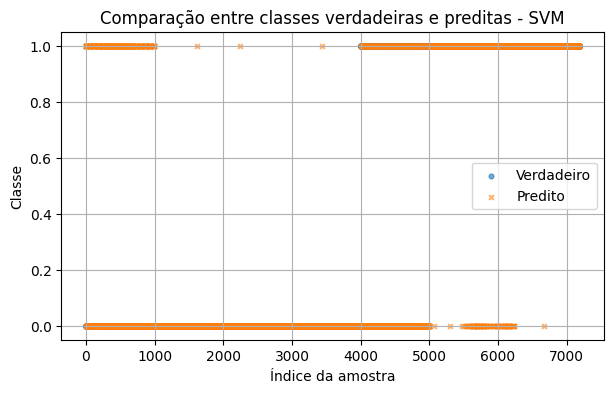

In [7]:
# =====================================================
# 9. Relatórios Avançados e Gráficos para o TCC (SVM)
# =====================================================
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, mean_absolute_error
import numpy as np
import time

# =====================================================
# 1. Curva ROC
# =====================================================
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - SVM CQCC")
plt.legend()
plt.grid(True)
plt.show()

print(f"AUC (Área sob a Curva ROC): {roc_auc:.4f}")


# =====================================================
# 2. Matriz de Confusão
# =====================================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Real", "Fake"],
            yticklabels=["Real", "Fake"])
plt.title("Matriz de Confusão - SVM CQCC")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()


# =====================================================
# 3. Distribuição das Probabilidades
# =====================================================
plt.figure(figsize=(7, 5))
sns.histplot(y_score[y_test == 0], label="Real", kde=True, stat="density")
sns.histplot(y_score[y_test == 1], label="Fake", kde=True, stat="density")
plt.title("Distribuição das Probabilidades por Classe - SVM CQCC")
plt.xlabel("Probabilidade prevista (classe Fake)")
plt.legend()
plt.grid(True)
plt.show()


# =====================================================
# 4. Métricas complementares
# =====================================================
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
mae       = mean_absolute_error(y_test, y_score)

print("===== MÉTRICAS COMPLEMENTARES =====")
print(f"Precisão (Precision): {precision:.4f}")
print(f"Recall (Sensibilidade): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MAE das Probabilidades: {mae:.4f}")


# =====================================================
# 5. Tempo de inferência do SVM
# =====================================================
start = time.time()
_ = svm.predict(X_test)
end = time.time()

avg_time = (end - start) / len(X_test)
fps = 1 / avg_time

print("\n===== DESEMPENHO DO MODELO SVM =====")
print(f"Tempo médio por amostra: {avg_time*1000:.3f} ms")
print(f"Amostras por segundo (FPS): {fps:.2f}")


# =====================================================
# 6. Comparação Verdadeiro vs Predito
# =====================================================
plt.figure(figsize=(7, 4))
plt.scatter(range(len(y_test)), y_test, s=12, alpha=0.6, label="Verdadeiro", marker="o")
plt.scatter(range(len(y_pred)), y_pred, s=12, alpha=0.6, label="Predito", marker="x")
plt.title("Comparação entre classes verdadeiras e preditas - SVM")
plt.xlabel("Índice da amostra")
plt.ylabel("Classe")
plt.legend()
plt.grid(True)
plt.show()